# Bayesian CNN

__Objective:__ experiment with a Bayesian CNN to classify images from the CIFAR-10 dataset.

__Source:__ [here](https://github.com/tensorchiefs/dl_book/blob/master/chapter_08/nb_ch08_01.ipynb)

In [1]:
# Execute on Colab.
!pip install keras_cv

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 803.1/803.1 kB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 13.9 MB/s eta 0:00:00


In [2]:
import tensorflow as tf
import tensorflow.keras.backend as K
import tensorflow_probability as tfp
import keras_cv
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

tfd = tfp.distributions

sns.set_theme()

Using TensorFlow backend


## Load data

In [9]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

# Create a validation set.
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.4)

print(
    'Training:', x_train.shape, y_train.shape,
    '\nValidation:', x_val.shape, y_val.shape,
    '\nTest:', x_test.shape, y_test.shape
)

Training: (30000, 32, 32, 3) (30000, 1) 
Validation: (20000, 32, 32, 3) (20000, 1) 
Test: (10000, 32, 32, 3) (10000, 1)


In [10]:
class_labels = {
    0: 'airplane',
    1: 'automobile',
    2: 'bird',
    3: 'cat',
    4: 'deer',
    5: 'dog',
    6: 'frog',
    7: 'horse',
    8: 'ship',
    9: 'truck'
}

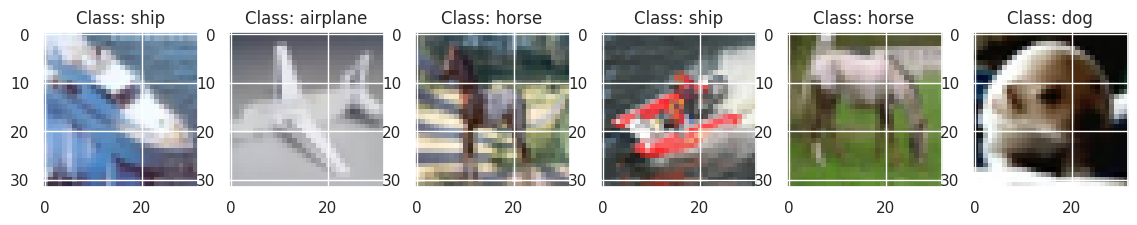

In [11]:
fig, axs = plt.subplots(nrows=1, ncols=6, figsize=(14, 6))

random_indices = tf.random.shuffle(tf.range(0, x_train.shape[0]))[:6]

for i, ax in enumerate(axs):
    ax.imshow(x_train[random_indices[i], ...])

    plt.sca(ax)
    plt.title(f'Class: {class_labels[y_train[random_indices[i]][0]]}')

### Preprocessing

In [12]:
def preprocess_data(x, y, class_to_eliminate=None):
    """
    """
    # Turn images to grayscale.
    # Shape transformation: (batch_shape, 32, 32, 3) -> (batch_shape, 32, 32, 1)
    # (a single channel).
    x_preprocessed = keras_cv.layers.Grayscale(output_channels=1)(x)

    # Convert data to tensors and normalize pixel values.
    x_preprocessed = tf.constant(x_preprocessed, dtype=tf.float32) / 255.

    # Change target tensor shape: (batch_shape, 1) -> (batch_shape,).
    y_preprocessed = y[:, 0]

    # Eliminate class if required.
    if class_to_eliminate is not None:
        x_preprocessed = x_preprocessed[y_preprocessed != class_to_eliminate]
        y_preprocessed = y_preprocessed[y_preprocessed != class_to_eliminate]

    # One-hot encode the targets.
    y_preprocessed = tf.one_hot(
        y_preprocessed,
        depth=10 if class_to_eliminate is None else 9
    )

    return x_preprocessed, y_preprocessed

In [13]:
x_train, y_train = preprocess_data(x_train, y_train, class_to_eliminate=7)
x_val, y_val = preprocess_data(x_val, y_val, class_to_eliminate=7)
x_test, y_test = preprocess_data(x_test, y_test)

print(
    'Training:', x_train.shape, y_train.shape,
    '\nValidation:', x_val.shape, y_val.shape,
    '\nTest:', x_test.shape, y_test.shape
)

Training: (26970, 32, 32, 1) (26970, 9) 
Validation: (18030, 32, 32, 1) (18030, 9) 
Test: (10000, 32, 32, 1) (10000, 10)


## Model building

Build a Bayesian CNN with `Convolution2DFlipout` layers. By default, only the kernel weights are treated in a Bayesian way: we could force the same for the bias terms but that would further increase the number of parameters (which is already doubled w.r.t. the non-Bayesian counterpart, as now for each of the original weights there are the $\mu$ and $\sigma$ parameters of its approximate posterior (variational distribution).

Observations:
- Adding batch normalization layers helps avoiding exploding gradients. These are usually put after the activation function following convolutional and dense layers.
- Once the minimum of the loss has been reached (given a value for the learning rate), increasing the batch size can help "squeeze" some information by computing more exact gradients.

### Test on a non-Bayesian CNN model

In [ ]:
class ClassicCNN(tf.keras.layers.Layer):
    """
    CNN network implemented as a Keras `Layer` subclass. See
    the `BayesianCNN` for the architecture: this is its
    non-bayesian counterpart.
    """
    def __init__(self):
        """
        """
        super().__init__()

        # Initialize the internal layers.
        self.conv_block_1 = [
            tf.keras.layers.Convolution2D(
                filters=8,
                kernel_size=(3, 3),
                padding='same',
                activation='relu'
            ),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.MaxPooling2D(pool_size=(2, 2))
        ]

        self.conv_block_2 = [
            tf.keras.layers.Convolution2D(
                filters=16,
                kernel_size=(3, 3),
                padding='same',
                activation='relu'
            ),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.MaxPooling2D(pool_size=(2, 2))
        ]

        self.flatten = tf.keras.layers.Flatten()

        self.dense_block = [
            tf.keras.layers.Dense(units=100, activation='relu'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dense(units=100, activation='relu'),
            tf.keras.layers.BatchNormalization()
        ]

        self.output_layer = tf.keras.layers.Dense(units=9, activation='softmax')

    def call(self, x):
        """
        Forward pass.
        """
        for conv_layer in self.conv_block_1:
            x = conv_layer(x)

        for conv_layer in self.conv_block_2:
            x = conv_layer(x)

        x = self.flatten(x)

        for dense_layer in self.dense_block:
            x = dense_layer(x)

        x = self.output_layer(x)

        return x


# Define callback to save/reload the model automatically every time
# training ends/starts.
backup_callback = tf.keras.callbacks.BackupAndRestore(
    backup_dir='./models/'
)

# Input has shape (32, 32, 3) for RGB images and (32, 32, 1)
# for grayscale ones.
inputs = tf.keras.layers.Input(shape=(32, 32, 1,))
outputs = ClassicCNN()(inputs)

cnn_model = tf.keras.Model(
    inputs=inputs,
    outputs=outputs
)

cnn_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

cnn_model.compile(
    loss='categorical_crossentropy',
    optimizer=cnn_optimizer,
    metrics=['accuracy']
)

cnn_model.summary()

In [ ]:
K.get_value(cnn_model.optimizer.lr)

In [ ]:
K.set_value(cnn_model.optimizer.lr, 1e-6)

print('New learning rate:', K.get_value(cnn_model.optimizer.lr))

In [ ]:
epochs = 1000

cnn_history = cnn_model.fit(
    x_train,
    y_train,
    validation_data=(x_val, y_val),
    epochs=epochs,
    batch_size=27007,
    callbacks=[backup_callback]
)

In [ ]:
# Loss history
fig = plt.figure(figsize=(14, 6))

sns.lineplot(
    x=range(len(cnn_history.history['loss'])),
    y=cnn_history.history['loss'],
    label='Total',
    color=sns.color_palette()[0]
)

plt.title('Training loss', fontsize=14)
plt.xlabel('Epoch')
plt.ylabel('Loss value')
plt.legend()

### Test on a Bayesian CNN model

Observations:
- The loss values in the Bayesian case around an order of magnitude bigger than in the non-Bayesian one. I think this is expected as VI adds the KL terms to the loss (one for each variational distribution).
- Training is more difficult, in that the NN seems to plateau on worse performance w.r.t. to the non-Bayesian case with the equivalent architecture. My impression is that there's a lot of noise in the training process (see points below).
- In the Bayesian CNN case, the loss tends to "bounce back up" at some point. This could be given by vanishing/exploding gradients.
- Batch normalization - while probably a good idea by analogy with the non-Bayesian case - doesn't fully solve the above problem.
- Increasing the batch size seems to be have a bigger effect on the above problem. Possible explanation: the Monte Carlo estimate of the NLL part of the loss adds noise to the loss itself, which probably adds noise to the gradients as well. This adds up with the noise already introduced by minibatch gradient descent (are these noise source with the same size?): increasing the batch size reduces at least one source of noise. **Note:** this seems to be true only after the problem has started - once the losss starts increasing, increasing the batch size seems to keep things manageable.
- If using SGD as an optimizer, adding momentum (common values are 0.9 or 0.5 increased to 0.9 after training stabililzes) seems to help.

General impressions:
- It looks like training reflects the presence of noise. Stabilizing the trajectory in parameters space (e.g. using a bigger batch size and/or momentum) seems to help.
- Even after complicating the model a bit, training seems to remain pretty slow (i.e. adding more parameters doesn't seem to immediately lead to better performance - at a cost of a more likely overfitting). Training just seems to be hard, almost regardless of the model...
- Training seems to be much slower than in the source followed for this example.

In [ ]:
bayesian_cnn_layer = BayesianCNN()

# Test.
bayesian_cnn_layer(x_train[:15]).shape

In [ ]:
# Test: the final softmax activation should normalize all output vectors
# to 1.
tf.reduce_sum(bayesian_cnn_layer(x_train[:15, ...]), axis=-1)

Build a Keras `Model` object.

In [ ]:
# Input has shape (32, 32, 3) for RGB images and (32, 32, 1)
# for grayscale ones.
inputs = tf.keras.Input(shape=(32, 32, 1,))

outputs = BayesianCNN()(inputs)

bayesian_cnn_model = tf.keras.Model(
    inputs=inputs,
    outputs=outputs
)

bayesian_cnn_model.summary()

Multiple predictions return different outputs.

In [ ]:
for _ in range(5):
    print(bayesian_cnn_model(x_test[:1, ...]))

Training.

In [38]:
def kernel_divergence_fn(q, p, _):
    """
    Note: KL divergence is NOT symmetric and it is assumed
          that the approximate posterior (variational
          distribution) is the FIRST entry and the prior
          is the SECOND one.
    """
    return tfd.kl_divergence(q, p) / (x_train.shape[0] * 1.)


class BayesianCNN(tf.keras.layers.Layer):
    """
    Keras `Layer` object implementing a Bayesian CNN. Structure:
      * Convolutional block (2 `Convolution2DFlipout` layers).
      * Maxpooling.
      * Convolutional block (2 `Convolution2DFlipout` layers).
      * Maxpooling.
      * Flattening.
      * Fully connected block (2 `DenseFlipout` layers and a
          final output one).
    """
    def __init__(self):
        """
        """
        super().__init__()

        # Initialize the internal layers.
        self.conv_block_1 = [
            tfp.layers.Convolution2DFlipout(
                8,
                kernel_size=(3, 3),
                padding='same',
                kernel_divergence_fn=kernel_divergence_fn
            ),
            tf.keras.activations.relu,
            tfp.layers.Convolution2DFlipout(
                8,
                kernel_size=(3, 3),
                padding='same',
                kernel_divergence_fn=kernel_divergence_fn
            ),
            tf.keras.activations.relu,
            # tf.keras.layers.LeakyReLU(),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.MaxPooling2D((2, 2))
        ]

        self.conv_block_2 = [
            tfp.layers.Convolution2DFlipout(
                16,
                kernel_size=(3, 3),
                padding='same',
                kernel_divergence_fn=kernel_divergence_fn
            ),
            tf.keras.activations.relu,
            tfp.layers.Convolution2DFlipout(
                16,
                kernel_size=(3, 3),
                padding='same',
                kernel_divergence_fn=kernel_divergence_fn
            ),
            tf.keras.activations.relu,
            # tf.keras.layers.LeakyReLU(),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.MaxPooling2D((2, 2))
        ]

        self.flatten = tf.keras.layers.Flatten()

        self.dense_block = [
            tfp.layers.DenseFlipout(
                units=100,
                kernel_divergence_fn=kernel_divergence_fn
            ),
            tf.keras.activations.relu,
            # tf.keras.layers.LeakyReLU(),
            tf.keras.layers.BatchNormalization(),
            tfp.layers.DenseFlipout(
                units=100,
                kernel_divergence_fn=kernel_divergence_fn
            ),
            tf.keras.activations.relu,
            # tf.keras.layers.LeakyReLU(),
            tf.keras.layers.BatchNormalization(),
        ]

        self.output_layer = tfp.layers.DenseFlipout(
            units=9,  # Selected number of classes.
            activation='softmax',
            kernel_divergence_fn=kernel_divergence_fn
        )

    def call(self, x):
        """
        Forward pass.
        """
        for conv_layer in self.conv_block_1:
            x = conv_layer(x)

        for conv_layer in self.conv_block_2:
            x = conv_layer(x)

        x = self.flatten(x)

        for dense_layer in self.dense_block:
            x = dense_layer(x)

        x = self.output_layer(x)

        return x


# Define callback to save/reload the model automatically every time
# training is stopped/started manually.
backup_callback = tf.keras.callbacks.BackupAndRestore(
    backup_dir='./models/'
)

# Recreate the model (for retraining purposes).
inputs = tf.keras.Input(shape=x_train.shape[1:])

outputs = BayesianCNN()(inputs)

bayesian_cnn_model = tf.keras.Model(
    inputs=inputs,
    outputs=outputs
)

bayesian_cnn_model.summary()

/usr/local/lib/python3.10/dist-packages/tensorflow_probability/python/layers/util.py:98: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  loc = add_variable_fn(
/usr/local/lib/python3.10/dist-packages/tensorflow_probability/python/layers/util.py:108: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  untransformed_scale = add_variable_fn(


Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 32, 32, 1)]       0         
                                                                 
 bayesian_cnn_4 (BayesianCN  (None, 9)                 235961    
 N)                                                              
                                                                 
Total params: 235961 (921.72 KB)
Trainable params: 235513 (919.97 KB)
Non-trainable params: 448 (1.75 KB)
_________________________________________________________________


In [47]:
learning_rate = 1e-4

optimizer = tf.keras.optimizers.SGD(
    learning_rate=learning_rate,
    momentum=0.9
)

bayesian_cnn_model.compile(
    loss='categorical_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy']
)

training_history = {
    'loss':[],
    'val_loss': [],
    'accuracy':[],
    'val_accuracy': []
}

In [48]:
K.set_value(bayesian_cnn_model.optimizer.lr, 1e-5)

print('New learning rate:', K.get_value(bayesian_cnn_model.optimizer.lr))

New learning rate: 1e-05


In [60]:
epochs = 1000

history = bayesian_cnn_model.fit(
    x_train,
    y_train,
    validation_data=(x_val, y_val),
    epochs=epochs,
    batch_size=1024,
    callbacks=[backup_callback]
)

Epoch 224/1000
27/27 [==============================] - 3s 101ms/step - loss: 12.6686 - accuracy: 0.2868 - val_loss: 12.6837 - val_accuracy: 0.2799
Epoch 225/1000
27/27 [==============================] - 2s 70ms/step - loss: 12.6608 - accuracy: 0.2914 - val_loss: 12.6883 - val_accuracy: 0.2824
Epoch 226/1000
27/27 [==============================] - 2s 70ms/step - loss: 12.6715 - accuracy: 0.2849 - val_loss: 12.6967 - val_accuracy: 0.2785
Epoch 227/1000
27/27 [==============================] - 2s 72ms/step - loss: 12.6676 - accuracy: 0.2853 - val_loss: 12.6817 - val_accuracy: 0.2764
Epoch 228/1000
27/27 [==============================] - 2s 76ms/step - loss: 12.6727 - accuracy: 0.2859 - val_loss: 12.6693 - val_accuracy: 0.2866
Epoch 229/1000
27/27 [==============================] - 3s 97ms/step - loss: 12.6722 - accuracy: 0.2814 - val_loss: 12.6840 - val_accuracy: 0.2776
Epoch 230/1000
27/27 [==============================] - 2s 75ms/step - loss: 12.6668 - accuracy: 0.2841 - val_loss: 1

KeyboardInterrupt: ignored

In [61]:
for k in bayesian_cnn_model.history.history.keys():
    training_history[k] += bayesian_cnn_model.history.history[k]

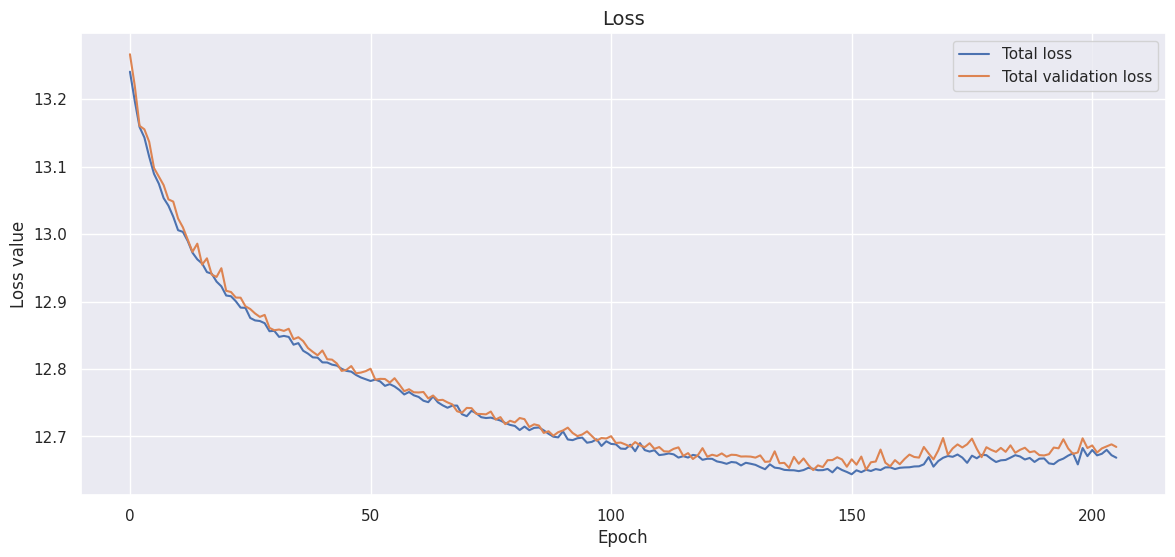

In [62]:
# Loss history
fig = plt.figure(figsize=(14, 6))

sns.lineplot(
    x=range(len(training_history['loss'])),
    y=training_history['loss'],
    color=sns.color_palette()[0],
    label='Total loss'
)

sns.lineplot(
    x=range(len(training_history['val_loss'])),
    y=training_history['val_loss'],
    color=sns.color_palette()[1],
    label='Total validation loss'
)

plt.title('Loss', fontsize=14)
plt.xlabel('Epoch')
plt.ylabel('Loss value')
plt.legend()

## Predictions

Predictions made by a probabilistic (Bayesian) model for classification are not only probability distributions over the classes, but probability distributions over the predicted probability themselves. Meaning: for each sample we predict for and for each possible class we don't predict just one value for the probability but rather a full distribution (which can be obtained a posteriori predicting multiple times for the same input, the Monte Carlo way).

In [93]:
# Indices of the test samples beloging to the
# classes the model has been trained on.
test_known_class_indices = tf.where(tf.math.argmax(y_test, axis=-1) != 9)[:, 0]

x_sample = x_test[test_known_class_indices[0]:+1, ...]
y_sample = y_test[test_known_class_indices[0], ...]

# Generate `n_pred` predictions for a single sample.
n_pred = 100

pred = []

for _ in range(n_pred):
    pred.append(bayesian_cnn_model(x_sample))

pred = tf.concat(pred, axis=0)

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

Text(0.5, 1.0, 'Distribution of predicted probabilities for each class (1 sample)')

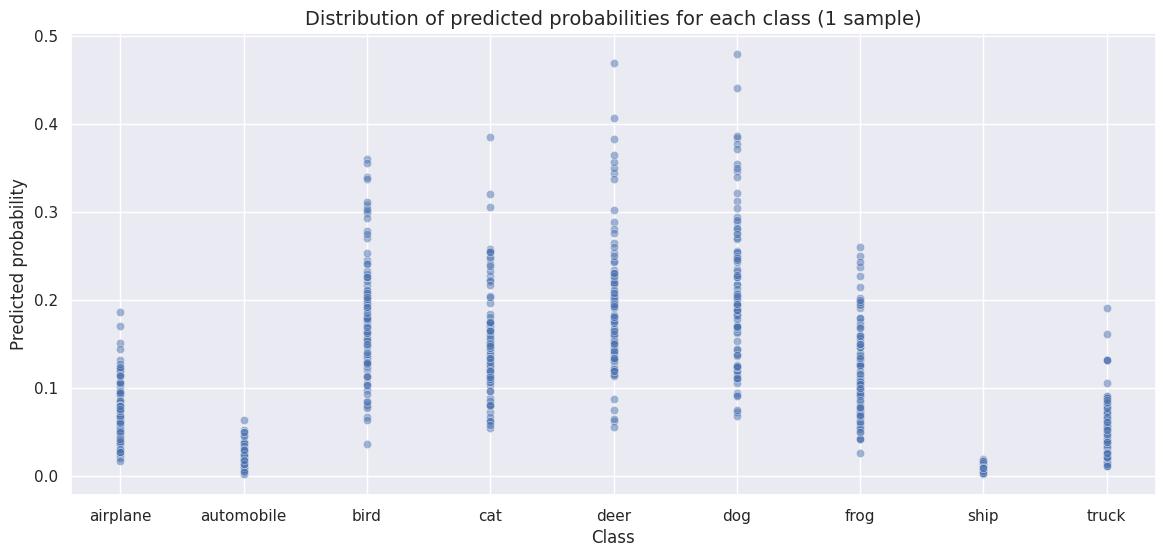

In [103]:
# Plot the distribution of predicted probabilities
# for each class.
fig = plt.figure(figsize=(14, 6))

for class_index in range(pred.shape[1]):
    sns.scatterplot(
        x=[class_index] * pred.shape[0],
        y=pred[:, class_index],
        alpha=.5,
        color=sns.color_palette()[0]
    )

plt.xticks(
    ticks=range(pred.shape[1]),
    labels=[class_labels[k] for k in sorted(class_labels.keys()) if k != 7]
)

plt.xlabel('Class')
plt.ylabel('Predicted probability')
plt.title('Distribution of predicted probabilities for each class (1 sample)', fontsize=14)

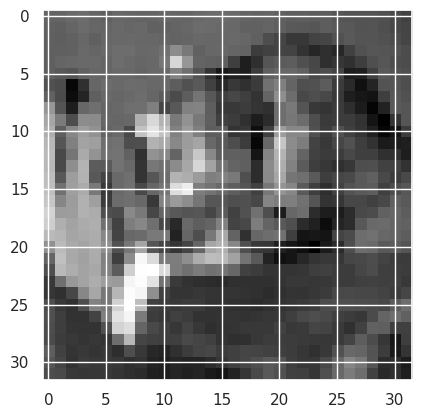

In [109]:
plt.imshow(x_sample[0, ...], cmap='gray')